### Assessing dynamic Functional Connectivity (dFC) using multiple methodologies

In this demo we will illustrate how to use the tools implemented in multi_analysis_dfc toolbox to assess dFC using multiple methodologies simultaneously.

We use sample data from an openneuro dataset by: Lukas Snoek and Maite van der Miesen and Andries van der Leij and Tinka Beemsterboer and Annemarie Eigenhuis and Steven Scholte (2020). AOMIC-PIOP1. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds002785.v2.0.0

In [1]:
import numpy as np
import time

### Parameters 

    1. Set the default hyperparameter values for different dFC assessment methods

In [2]:
params_methods = {
    # Sliding Parameters
    # W is in sec
    'W': 44, 'n_overlap': 0.5, 'sw_method':'pear_corr', 'tapered_window':True,
    # TIME_FREQ
    'TF_method':'WTC',
    # CLUSTERING AND DHMM
    'clstr_base_measure':'SlidingWindow',
    # HMM
    'hmm_iter': 30, 'dhmm_obs_state_ratio': 16/24, 
    # State Parameters
    'n_states': 12, 'n_subj_clstrs': 20,
    # Parallelization Parameters
    'n_jobs': 2, 'verbose': 0, 'backend': 'loky',
    # SESSION
    'session': 'rest',
    # data parameters
    'normalization': True,
}

    2. Specify the list of methods you want to include in the multi-analysis:

In [3]:
MEASURES_name_lst = [ 
                'SlidingWindow', 
                # 'Time-Freq', 
                # 'CAP', 
                # 'ContinuousHMM', 
                'Windowless', 
                # 'Clustering', 
                # 'DiscreteHMM' 
]

    3. You may set a list of alternative values for each hyperparameter

Here for example, we want to run the analysis also with 6 number of states:

In [4]:
alter_hparams = { 
            'n_states': [6], 
}

    4. Set parameter values for multi-analysis

In [5]:
params_dFC_analyzer = { 
    # Parallelization Parameters
    'n_jobs': None, 'verbose': 0, 'backend': 'loky' 
}

### LOAD DATA

    Download resting state fMRI data of 2 subjects from OpenNeuro website:

In [6]:
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=UfCs4xtwIEPDgmb32qFbtMokl_jxLUKr -o sample_data/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0001/func/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=biaIJGNQ22P1l1xEsajVzUW6cnu1_8lD -o sample_data/sub-0001_task-restingstate_acq-mb3_desc-confounds_regressors.tsv
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0002/func/sub-0002_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz?versionId=fUBWmUTg6vfe2n.ywDNms4mOAW3r6E9Y -o sample_data/sub-0002_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
!curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds002785/derivatives/fmriprep/sub-0002/func/sub-0002_task-restingstate_acq-mb3_desc-confounds_regressors.tsv?versionId=2zWQIugU.J6ilTFObWGznJdSABbaTx9F -o sample_data/sub-0002_task-restingstate_acq-mb3_desc-confounds_regressors.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  370M  100  370M    0     0  12.0M      0  0:00:30  0:00:30 --:--:-- 13.3M      0  0:00:50  0:00:06  0:00:44 7459k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2230k  100 2230k    0     0  3710k      0 --:--:-- --:--:-- --:--:-- 3748k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  352M  100  352M    0     0  11.9M      0  0:00:29  0:00:29 --:--:-- 13.4MM      0  0:00:30  0:00:22  0:00:08 13.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2830k  100 2830k    0     0  3470k      0 --:-

    Load the downloaded nifti files of both subjects as a TimeSeries object:

In [7]:
from multi_analysis_dfc import data_loader

subj_id_list = ['sub-0001', 'sub-0002']
nifti_files_list = []
for subj_id in subj_id_list:
    nifti_files_list.append(
        'sample_data/'+subj_id+'_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    )

BOLD_multi = {
    'rest': data_loader.multi_nifti2timeseries(
                    nifti_files_list,
                    subj_id_list,
                    n_rois=100, Fs=1/0.75,
                    confound_strategy='no_motion', 
                    standardize=False,
                    TS_name=None,
                    session=None,
            )   
}

/Users/mte/opt/anaconda3/envs/multi_analysis_dfc_env/lib/python3.8/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/Users/mte/opt/anaconda3/envs/multi_analysis_dfc_env/lib/python3.8/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return s

This is how the info dictionary of the loaded TimeSeries look like:

In [8]:
BOLD_multi['rest'].info

n_time
	477
n_regions
	100
Fs
	1.33
Fs_ratio
	1.00
noise_ratio
	0.00
nodes_lst
	 0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 97.00 98.00 99.00 
node_labels
	7Networks_LH_Vis_1
	7Networks_LH_Vis_2
	7Networks_LH_Vis_3
	7Networks_LH_Vis_4
	7Networks_LH_Vis_5
	7Networks_LH_Vis_6
	7Networks_LH_Vis_7
	7Networks_LH_Vis_8
	7Networks_LH_Vis_9
	7Networks_LH_SomMot_1
	7Networks_LH_SomMot_2
	7Networks_LH_SomMot_3
	7Networks_LH_SomMot_4
	7Networks_LH_SomMot_5
	7Networks_LH_SomMot_

This is how the BOLD signals look like:

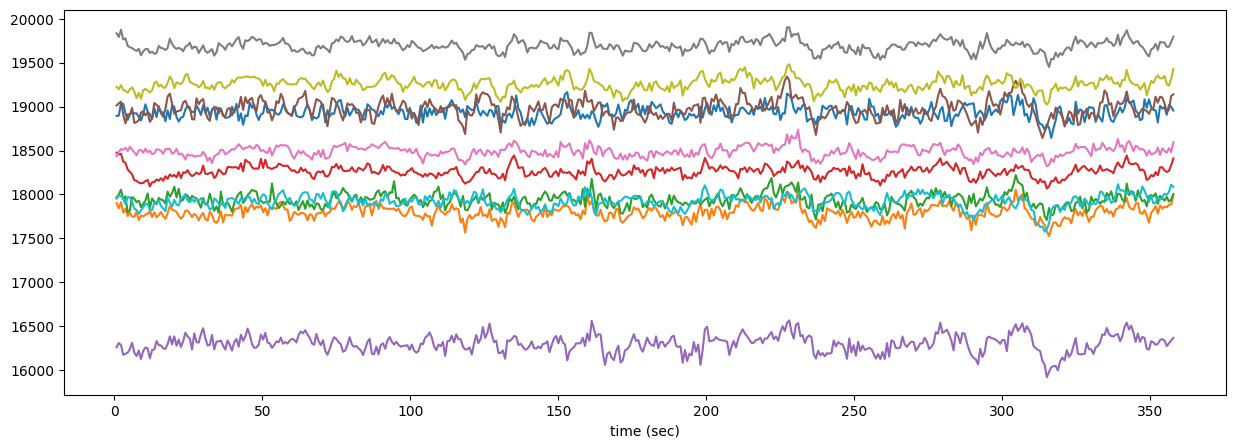

In [9]:
BOLD_multi['rest'].visualize(
    start_time=0, end_time=1000, 
    nodes_lst=range(10), 
)

### Measures of dFC 

    1. Create dFC Multi-Analysis object:

In [10]:
from multi_analysis_dfc import MultiAnalysis

MA = MultiAnalysis( 
    analysis_name='dFC variability assessment', 
    **params_dFC_analyzer 
)

    2. Initialize the list of measures with the given default and alternative hyperparameter values

In [11]:
MEASURES_lst = MA.measures_initializer( 
    MEASURES_name_lst, 
    params_methods, 
    alter_hparams 
)

There are one instance of SlidingWindow, and two instances of Window-less, one with 12 states and the other one with 6 states.

In [12]:
print(MEASURES_lst)

[<multi_analysis_dfc.dfc_methods.sliding_window.SLIDING_WINDOW object at 0x7f7969398f10>, <multi_analysis_dfc.dfc_methods.windowless.WINDOWLESS object at 0x7f7969398c10>, <multi_analysis_dfc.dfc_methods.windowless.WINDOWLESS object at 0x7f7969398fa0>]


### estimate FC states

    Run FCS estimation for state-based methods only and collect all methods in MEASURES_fit_lst

In [13]:
tic = time.time()
print('Measurement Started ...')

MEASURES_fit_lst = list()
for measure in MEASURES_lst:

    time_series = BOLD_multi['rest']
    if measure.is_state_based:
        measure.estimate_FCS(time_series=time_series)
    MEASURES_fit_lst.append(measure)
            
print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

# pass the measures to the MultiAnalysis object
MA.set_MEASURES_fit_lst(MEASURES_fit_lst)

Measurement Started ...
Measurement required 1.107 seconds.


How info dictionary of a measure looks like (e.g. for the SlidingWindow object):

In [14]:
MEASURES_fit_lst[0].info

{'measure_name': 'SlidingWindow',
 'is_state_based': False,
 'sw_method': 'pear_corr',
 'tapered_window': True,
 'W': 44,
 'n_overlap': 0.5,
 'normalization': True,
 'num_select_nodes': None,
 'num_time_point': None,
 'Fs_ratio': None,
 'noise_ratio': None,
 'num_realization': None,
 'session': 'rest'}

### dFC assessment

    Assess each subject's dFC using the fitted measure objects and collect them in `SUBJ_dFC_dict`

In [15]:
tic = time.time()
print('Measurement Started ...')

print("dFC estimation started...")

SUBJ_dFC_dict = {}
for subj in ['sub-0001', 'sub-0002']:
    # get the time series for this subject
    BOLD = {'rest': BOLD_multi['rest'].get_subj_ts(subjs_id=subj)}
    # estimate the dFC for this subject using the MultiAnalysis object 
    # and all the measures passed to it simultaneously
    dFC_dict = MA.subj_lvl_dFC_assess(time_series_dict=BOLD)
    SUBJ_dFC_dict[subj] = dFC_dict

print("dFC estimation done.")
print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

Measurement Started ...
dFC estimation started...
dFC estimation done.
Measurement required 23.401 seconds.


    VISUALIZE dFC obtained by different methods for one of the subjects

measure: SlidingWindow
measure: Windowless, num_states: 12
measure: Windowless, num_states: 6


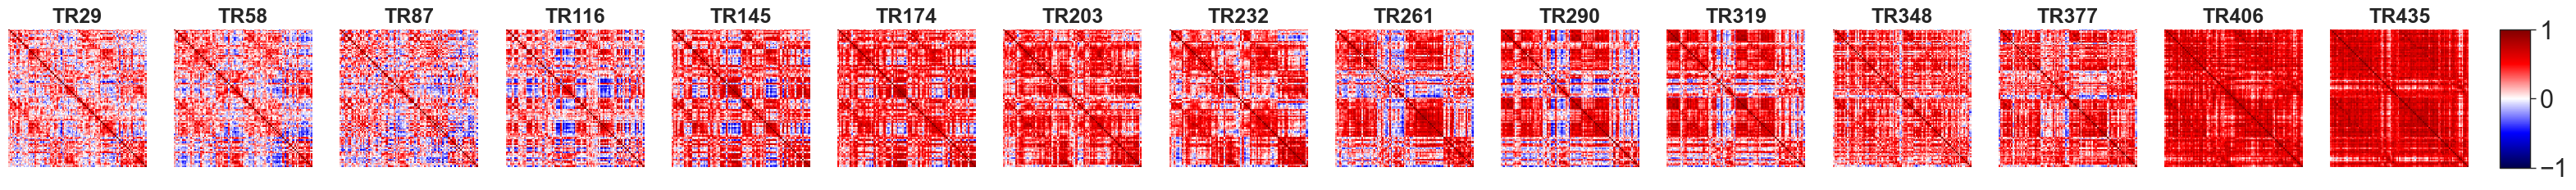

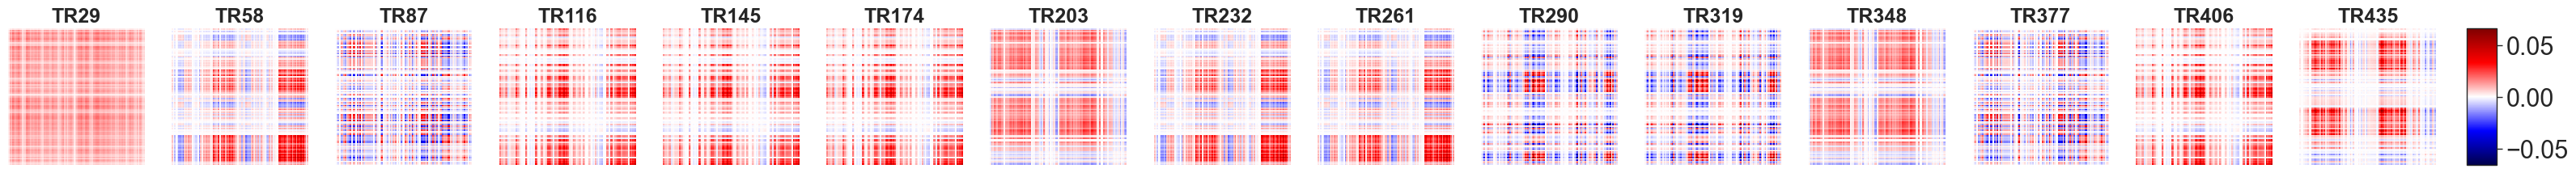

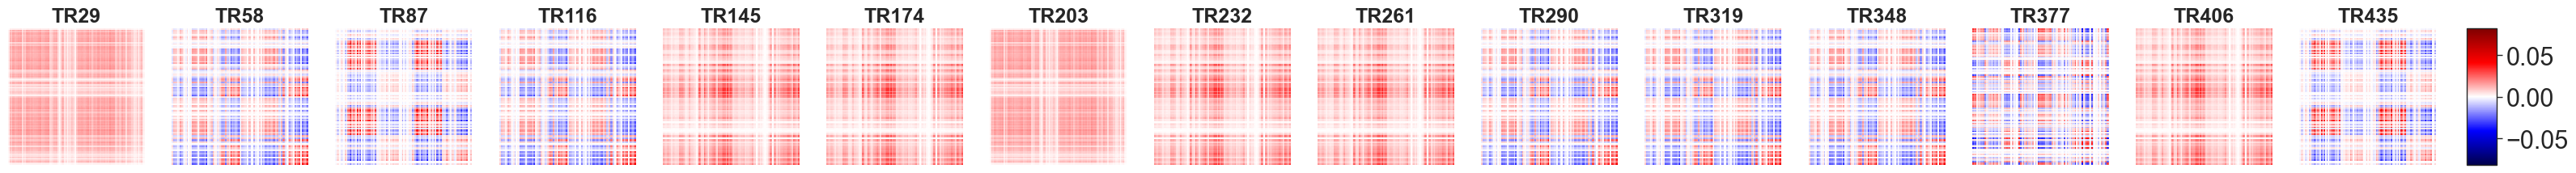

In [16]:
from turtle import title
from multi_analysis_dfc.dfc_utils import TR_intersection

dFC_lst = SUBJ_dFC_dict['sub-0001']['dFC_lst']

TRs = TR_intersection(dFC_lst)
chosen_TRs = TRs[:]

for dFC in dFC_lst:
    if dFC.measure.is_state_based:
        print(f"measure: {dFC.measure.measure_name}, num_states: {dFC.measure.params['n_states']}")
    else:
        print(f"measure: {dFC.measure.measure_name}")
    dFC.visualize_dFC(TRs=chosen_TRs, normalize=False, fix_lim=False)

### Similarity assessment

Assess the similarity of dFC obtained by different methods (those with default hyperparameter values) for one of the subjects using the `comparison` module

In [17]:
from multi_analysis_dfc.comparison import SimilarityAssessment

dFC_lst = SUBJ_dFC_dict['sub-0001']['dFC_lst']
similarity_assessment = SimilarityAssessment(dFC_lst=dFC_lst)

tic = time.time()
print('Measurement Started ...')

print("Similarity measurement started...")
SUBJ_output = similarity_assessment.run(FILTERS=MA.hyper_param_info, downsampling_method='default')
print("Similarity measurement done.")

print('Measurement required %0.3f seconds.' % (time.time() - tic, ))

Measurement Started ...
Similarity measurement started...


Similarity measurement done.
Measurement required 36.705 seconds.


This is what similarity results of each subject (`SUBJ_output`) contain:

In [18]:
print(SUBJ_output.keys())
print(SUBJ_output['default_values'].keys())

dict_keys(['default_values', 'n_states_6'])
dict_keys(['measure_lst', 'TS_info_lst', 'common_TRs', 'dFC_samples', 'time_record_dict', 'all', 'feature_based', 'graph_based', 'dFC_avg', 'dFC_var', 'FO', 'transition_stats'])


### Post Analysis

    1. Create a dictionary containing RESULTS using `SUBJ_output` to be visualized

In [19]:
metric = 'spearman' # the similarity metric, this is one of the keys/similarity measures in the similarity dictionary
filter = 'default_values' # show the results for the methods with default hyperparameter values

similarity_mat = np.squeeze(SUBJ_output[filter]['all'][metric])
methods_names = [measure.measure_name for measure in SUBJ_output[filter]['measure_lst']]
RESULTS = {
    'rest':{
                'similarity_mat':similarity_mat,
                'methods_names':methods_names
            }
}

    2. VISUALIZE Similarity results

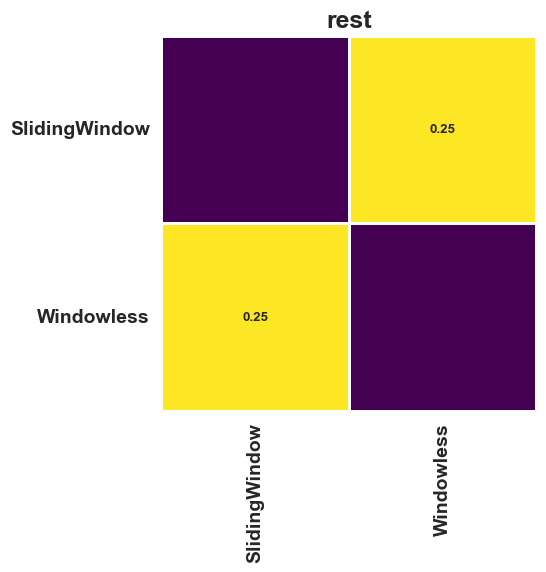

In [20]:
from multi_analysis_dfc.comparison.plotting import visualize_sim_mat

visualize_sim_mat(
    RESULTS, 
    mat_key='similarity_mat', 
    name_lst_key='methods_names', 
    cmap='viridis',
)